# **Task 6: Music Genre Classification**
- To classify songs into genres using extracted audio features (e.g., MFCCs).
- To compare traditional machine learning models with deep learning (CNNs).
- To evaluate the impact of transfer learning and spectrogram-based methods.

In [196]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [3]:
path = "/content/drive/MyDrive/Machine learning/20CS36/Music Genre/Data/"

In [4]:
df = pd.read_csv(path+ "features_30_sec.csv")

In [5]:
RND = 42
np.random.seed(RND)

In [6]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [8]:
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(10))



Missing values per column:
filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
dtype: int64


In [9]:
if 'filename' in df.columns:
    dup_count = df['filename'].duplicated().sum()
    print(f"\nDuplicate filenames: {dup_count}")



Duplicate filenames: 0


In [10]:
df['label'].value_counts()

,count
label,
blues,100
classical,100
country,100
disco,100
hiphop,100
jazz,100
metal,100
pop,100
reggae,100


In [11]:
df.duplicated().sum()

np.int64(0)

### **Class distribution bar plot**

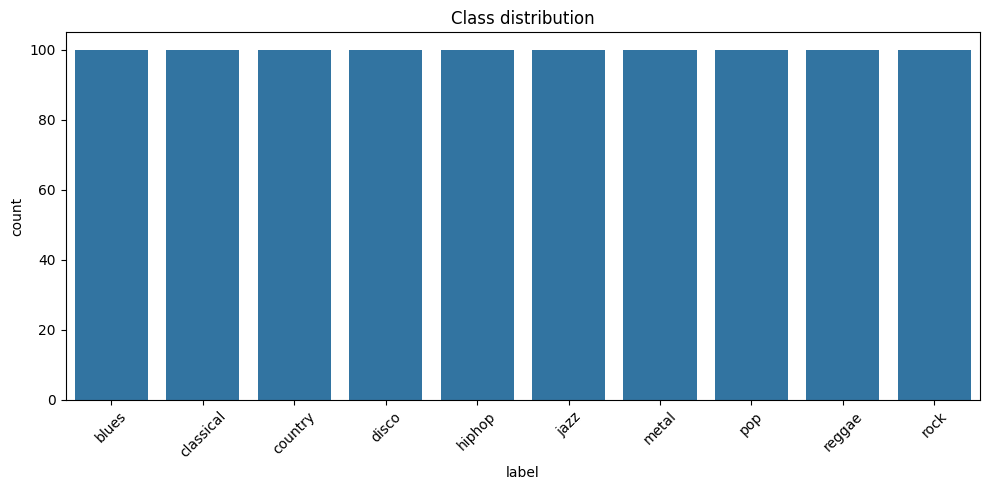

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Class distribution')
plt.tight_layout()
plt.show()

In [13]:
print("\nNumeric summary (first 10 features):")
display(df.select_dtypes(include=[np.number]).iloc[:, :10].describe().T)



Numeric summary (first 10 features):


,count,mean,std,min,25%,50%,75%,max
length,1000.0,662030.846000,1784.073992,660000.000000,661504.000000,661794.000000,661794.000000,6.758080e+05
chroma_stft_mean,1000.0,0.378682,0.081705,0.171939,0.319562,0.383148,0.435942,6.636847e-01
chroma_stft_var,1000.0,0.086340,0.007735,0.044555,0.082298,0.086615,0.091256,1.081115e-01
rms_mean,1000.0,0.130930,0.065683,0.005276,0.086657,0.122443,0.175682,3.979734e-01
rms_var,1000.0,0.003051,0.003634,0.000004,0.000942,0.001816,0.003577,2.767948e-02
spectral_centroid_mean,1000.0,2201.780898,715.960600,570.040355,1627.697311,2209.263090,2691.294667,4.435244e+03
spectral_centroid_var,1000.0,469691.574888,400899.517468,7911.251394,184350.530174,338486.152674,612147.934781,3.036843e+06
spectral_bandwidth_mean,1000.0,2242.541070,526.316473,898.066208,1907.240605,2221.392843,2578.469836,3.509646e+03
spectral_bandwidth_var,1000.0,137079.155165,96455.666326,10787.185064,67376.554428,111977.548036,182371.576801,6.947848e+05
rolloff_mean,1000.0,4571.549304,1574.791602,749.140636,3380.069642,4658.524473,5533.810460,8.677673e+03


### **Distribution plots for a few representative features**

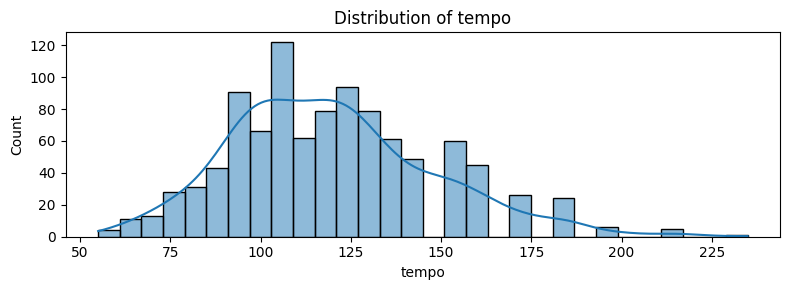

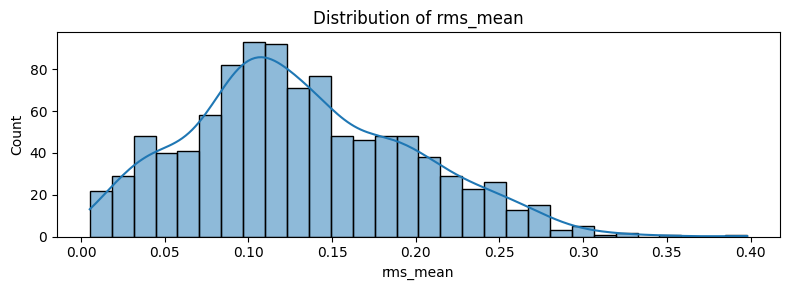

In [14]:
features_to_plot = ['tempo', 'rms_mean']
for feat in features_to_plot:
    if feat in df.columns:
        plt.figure(figsize=(8,3))
        sns.histplot(df[feat], kde=True, bins=30)
        plt.title(f'Distribution of {feat}')
        plt.tight_layout()
        plt.show()


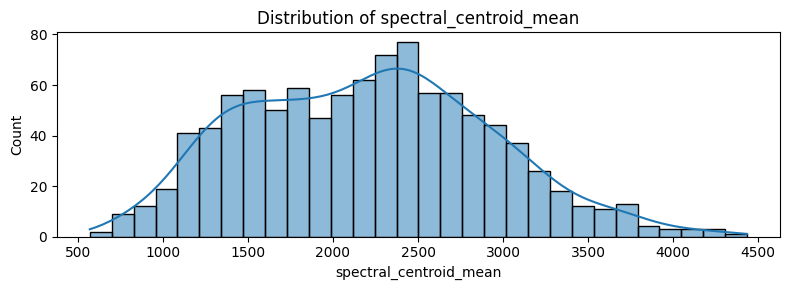

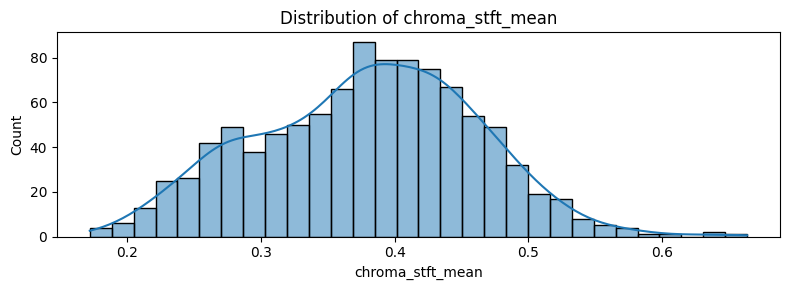

In [15]:
features_to_plot = ['spectral_centroid_mean', 'chroma_stft_mean']
for feat in features_to_plot:
    if feat in df.columns:
        plt.figure(figsize=(8,3))
        sns.histplot(df[feat], kde=True, bins=30)
        plt.title(f'Distribution of {feat}')
        plt.tight_layout()
        plt.show()


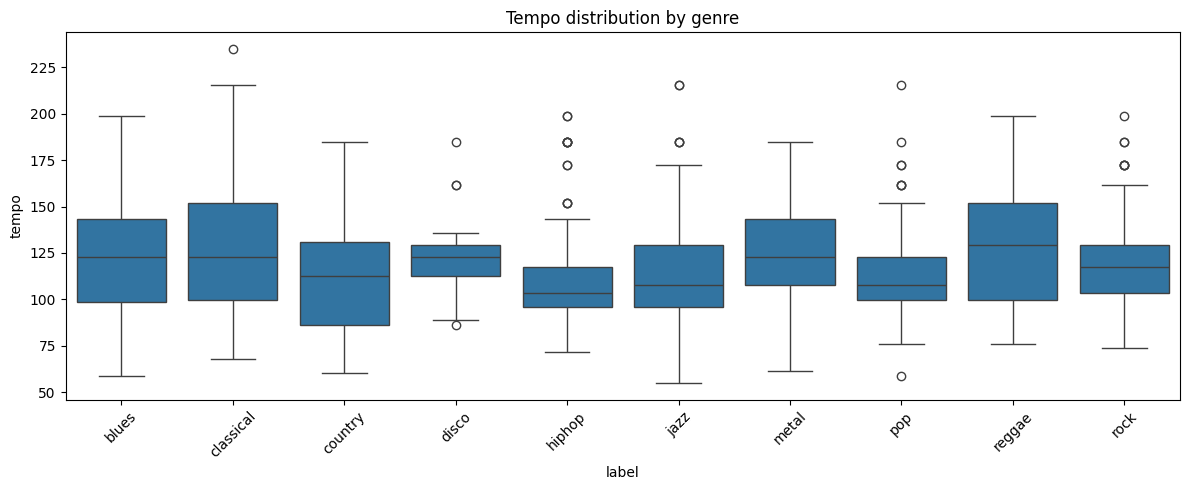

In [16]:
if 'tempo' in df.columns:
    plt.figure(figsize=(12,5))
    sns.boxplot(x='label', y='tempo', data=df)
    plt.xticks(rotation=45)
    plt.title('Tempo distribution by genre')
    plt.tight_layout()
    plt.show()

### **Correlation heatmap (top features by variance)**

In [17]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
variances = df[numeric_cols].var().sort_values(ascending=False)
top_feats = variances.index[:20].tolist()

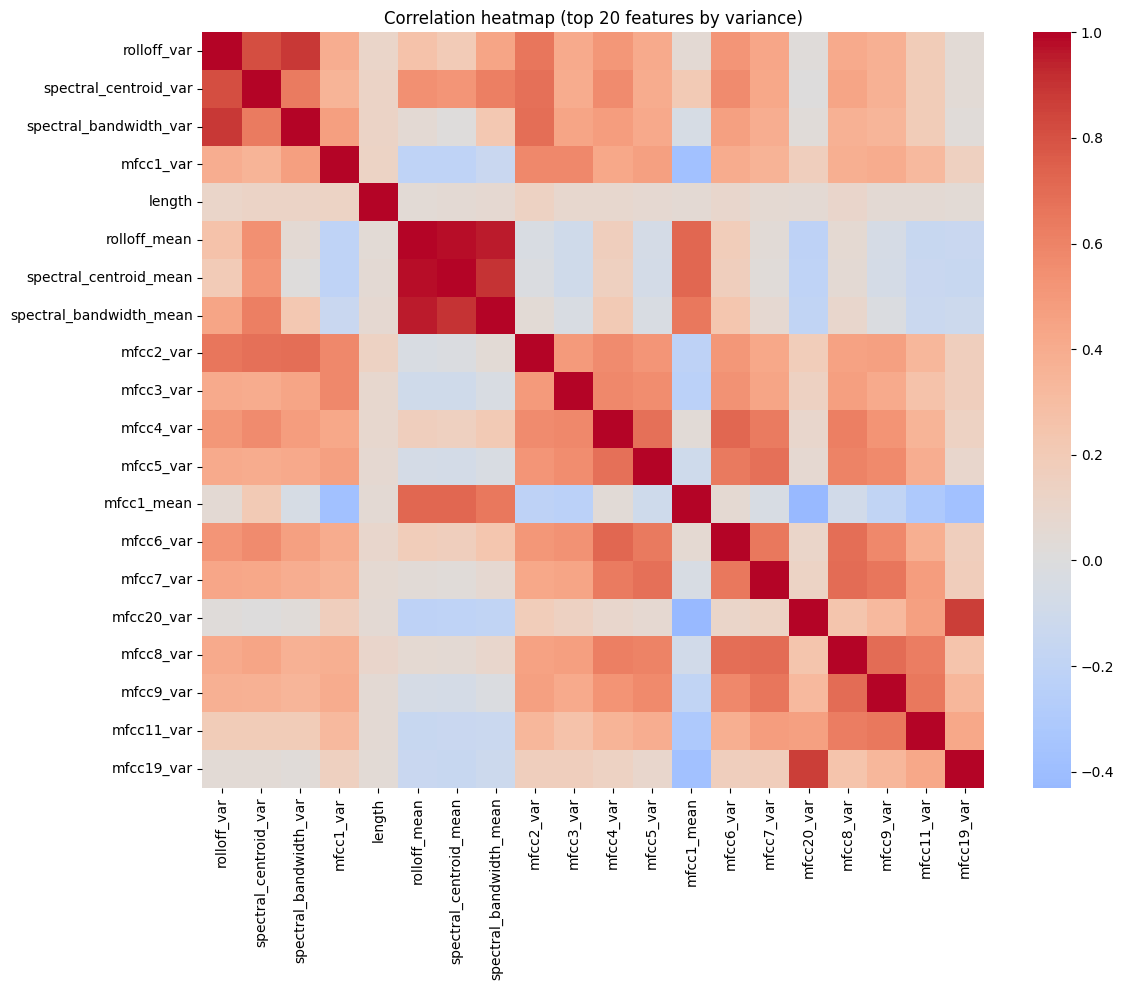

In [18]:

plt.figure(figsize=(12,10))
corr = df[top_feats].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation heatmap (top 20 features by variance)')
plt.tight_layout()
plt.show()

### **PCA for 2d visualization (shows separation)**

In [19]:
from sklearn.decomposition import PCA


In [20]:
# Prepare X (drop filename and label)
X_all = df.drop(['filename','label'], axis=1, errors='ignore')
y_all = df['label'].copy()

scaler_vis = StandardScaler()
X_scaled_vis = scaler_vis.fit_transform(X_all)

pca = PCA(n_components=2, random_state=RND)
X_pca = pca.fit_transform(X_scaled_vis)


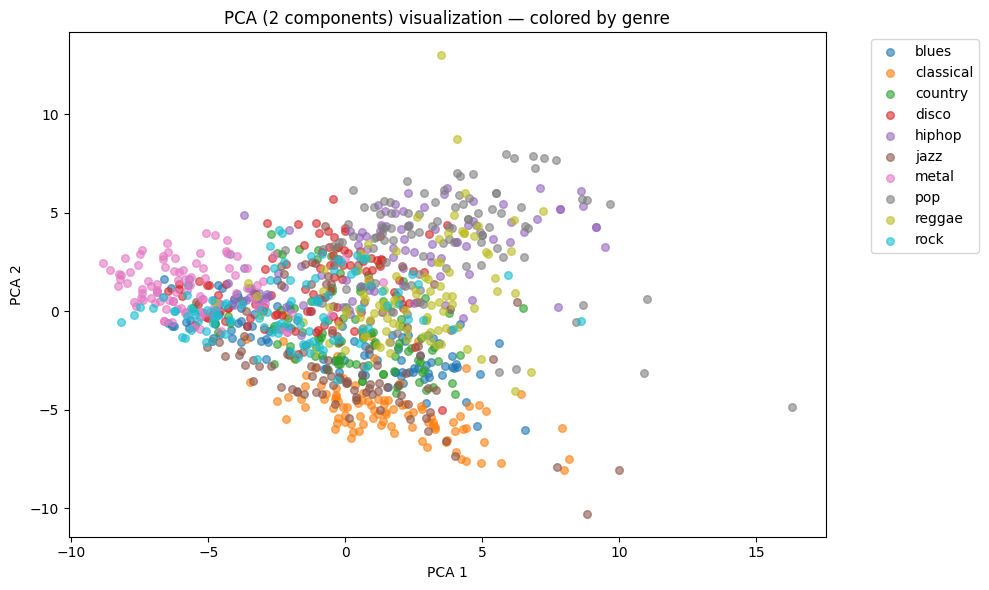

In [21]:
plt.figure(figsize=(10,6))
unique_labels = y_all.unique()
label_encoder_viz = LabelEncoder()
y_enc_viz = label_encoder_viz.fit_transform(y_all)

palette = sns.color_palette("tab10", n_colors=len(unique_labels))
for lab_id in np.unique(y_enc_viz):
    plt.scatter(X_pca[y_enc_viz==lab_id,0],
                X_pca[y_enc_viz==lab_id,1],
                label=label_encoder_viz.inverse_transform([lab_id])[0],
                alpha=0.6, s=30)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA (2 components) visualization — colored by genre')
plt.tight_layout()
plt.show()


### **Preprocessing for modeling**

In [22]:
X = df.drop(['filename','label'], axis=1, errors='ignore')  # all numeric features
y = df['label'].copy()

le = LabelEncoder()
y_enc = le.fit_transform(y)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nLabel mapping (label -> encoded):")
print(label_mapping)



Label mapping (label -> encoded):
{'blues': np.int64(0), 'classical': np.int64(1), 'country': np.int64(2), 'disco': np.int64(3), 'hiphop': np.int64(4), 'jazz': np.int64(5), 'metal': np.int64(6), 'pop': np.int64(7), 'reggae': np.int64(8), 'rock': np.int64(9)}


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.20, random_state=RND, stratify=y_enc)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (800, 58), Test shape: (200, 58)


In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
rf = RandomForestClassifier(n_estimators=200, random_state=RND, n_jobs=-1)
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [26]:
y_pred = rf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\nRandomForest test accuracy: {acc:.4f}\n")



RandomForest test accuracy: 0.7800



In [27]:
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification report:
              precision    recall  f1-score   support

       blues       0.83      0.75      0.79        20
   classical       0.83      0.95      0.88        20
     country       0.70      0.80      0.74        20
       disco       0.75      0.60      0.67        20
      hiphop       0.67      0.80      0.73        20
        jazz       0.76      0.80      0.78        20
       metal       0.89      0.85      0.87        20
         pop       0.85      0.85      0.85        20
      reggae       0.76      0.80      0.78        20
        rock       0.80      0.60      0.69        20

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



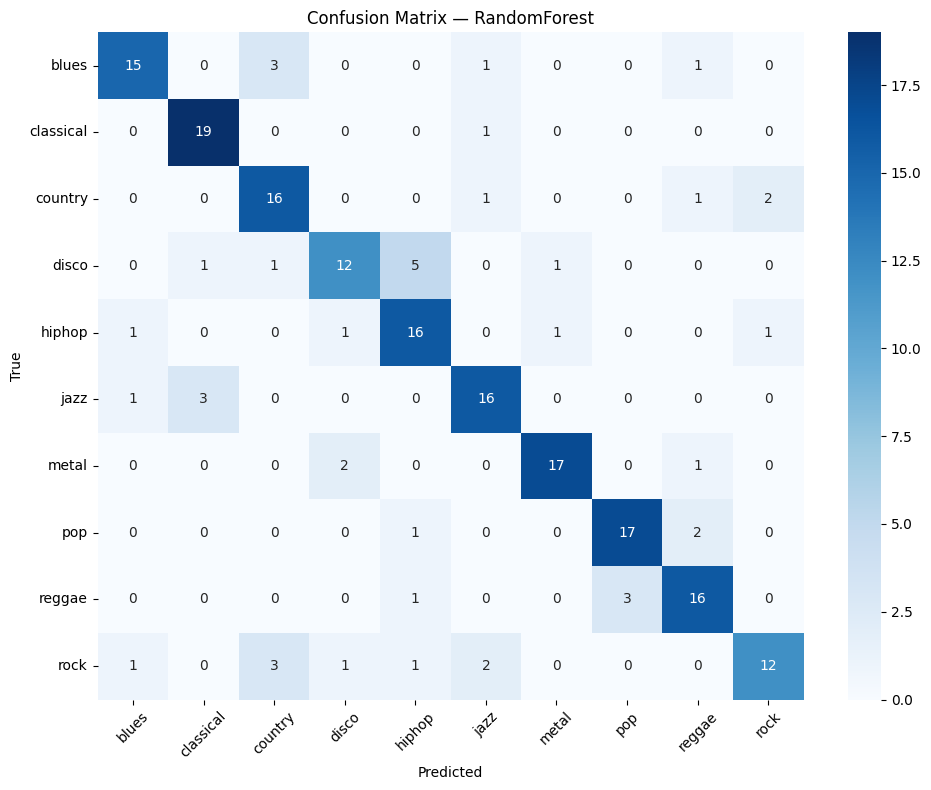

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — RandomForest')
plt.tight_layout()
plt.show()

In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
cv_scores = cross_val_score(rf, scaler.transform(X), y_enc, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"5-fold CV accuracies: {np.round(cv_scores, 4)}")
print(f"CV mean accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


5-fold CV accuracies: [0.765 0.775 0.795 0.82  0.77 ]
CV mean accuracy: 0.7850 ± 0.0202


In [30]:
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
top_k = 15
print(f"\nTop {top_k} important features:")
display(feat_importances.head(top_k))


Top 15 important features:


,0
chroma_stft_mean,0.042144
perceptr_var,0.039256
length,0.038826
rms_var,0.030931
mfcc4_mean,0.029445
spectral_bandwidth_mean,0.029409
chroma_stft_var,0.028423
rms_mean,0.026158
mfcc1_mean,0.025868
mfcc5_var,0.024594


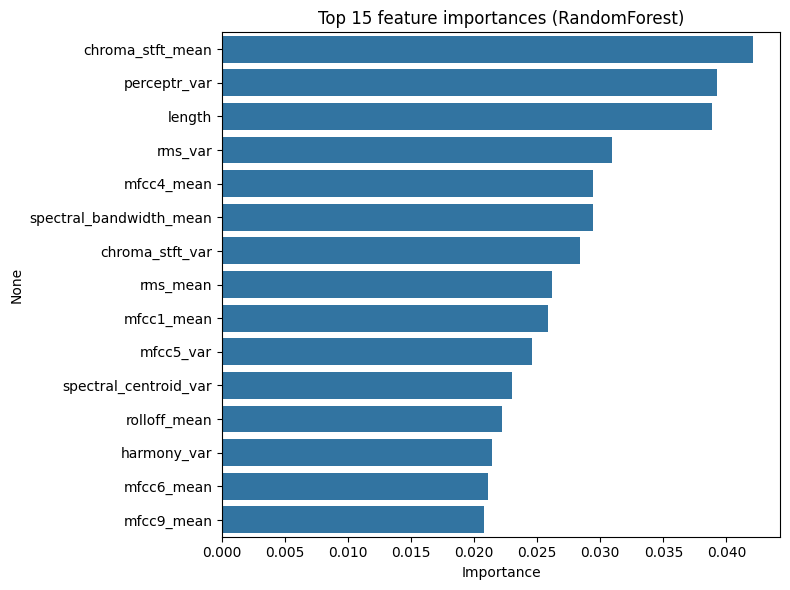

In [31]:
plt.figure(figsize=(8,6))
sns.barplot(x=feat_importances.head(top_k).values, y=feat_importances.head(top_k).index)
plt.title(f'Top {top_k} feature importances (RandomForest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [32]:
model_save_path = 'rf_music_genre.joblib'
joblib.dump({'model': rf, 'scaler': scaler, 'label_encoder': le}, model_save_path)
print(f"\nSaved model+scaler+label_encoder to {model_save_path}")



Saved model+scaler+label_encoder to rf_music_genre.joblib


### **Image-Based Genre Classification (CNN)**

In [197]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [198]:
data_dir = "/content/drive/MyDrive/Machine learning/20CS36/Music Genre/Data/images_original/"

In [199]:
img_size = (128, 128)
batch_size = 32

In [200]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)



In [202]:
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode="categorical",
    subset="training"
)


Found 800 images belonging to 10 classes.


In [204]:
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode="categorical",
    subset="validation"
)

Found 199 images belonging to 10 classes.


In [205]:
num_classes = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)


Classes: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


### **CNN model**

In [206]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Compile**

In [207]:
model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [208]:
print(model.summary())

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 58, 58, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,289,866 (77.40 MB)

 Trainable params: 20,288,970 (77.40 MB)

 Non-trainable params: 896 (3.50 KB)

None


In [209]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    shuffle=True
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - accuracy: 0.1931 - loss: 3.1801 - val_accuracy: 0.1005 - val_loss: 2.4391
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.4470 - loss: 1.4841 - val_accuracy: 0.1005 - val_loss: 3.0829
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.6760 - loss: 0.9685 - val_accuracy: 0.1005 - val_loss: 3.5072
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.7836 - loss: 0.6749 - val_accuracy: 0.1005 - val_loss: 3.7995
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9048 - loss: 0.3301 - val_accuracy: 0.1005 - val_loss: 4.6343
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9939 - loss: 0.1081 - val_accuracy: 0.1005 - val_loss: 5.3083
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 0.0564 - val_accuracy: 0.1005 - val_loss: 5.4690
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 0.0226 - val_acc

In [211]:
train_loss, train_acc = model.evaluate(train_gen, verbose=0)
val_loss, val_acc = model.evaluate(val_gen, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Train Accuracy: 1.0000
Validation Accuracy: 0.5528


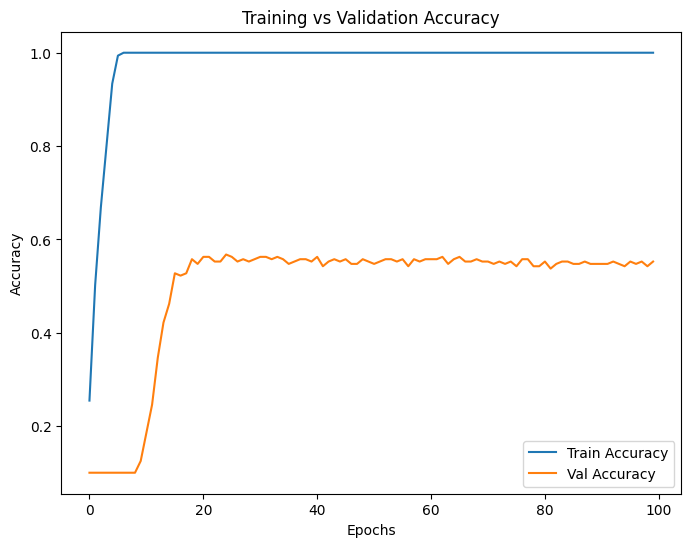

In [215]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()



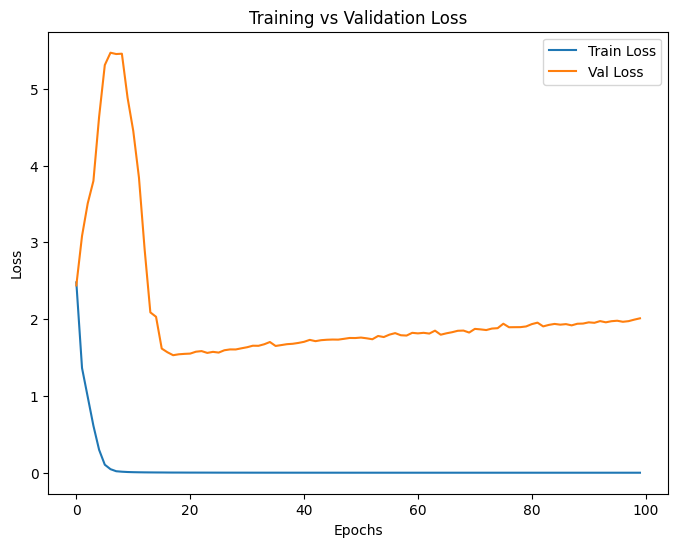

In [216]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()



13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step


<Figure size 800x600 with 0 Axes>

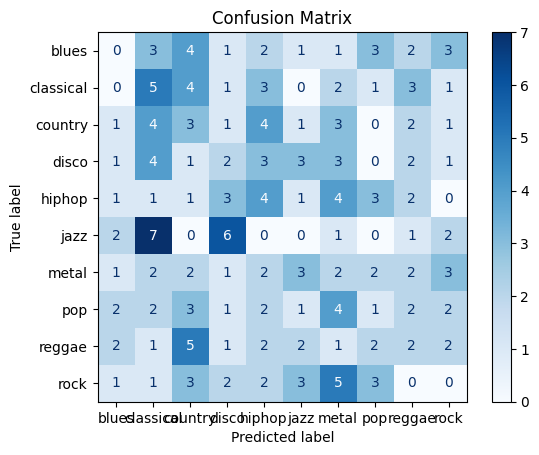

In [214]:
val_gen.reset()
y_true = val_gen.classes
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_gen.class_indices.keys()))

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


### **ResNet50 Pretrained Model**

In [229]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [276]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [278]:
train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)



Found 800 images belonging to 10 classes.


In [279]:
val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 199 images belonging to 10 classes.


In [280]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False



In [285]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2048, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

output = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

In [286]:
opt = Adam(learning_rate=1e-3)  # faster start
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])


In [287]:
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_18[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 30,426,506 (116.07 MB)

 Trainable params: 23,782,154 (90.72 MB)

 Non-trainable params: 6,644,352 (25.35 MB)

In [288]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-6, verbose=1)
]


In [289]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.1464 - loss: 3.3383 - val_accuracy: 0.1005 - val_loss: 889.2647 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 692ms/step - accuracy: 0.1652 - loss: 2.6798 - val_accuracy: 0.1005 - val_loss: 396.3290 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 783ms/step - accuracy: 0.2078 - loss: 2.4097 - val_accuracy: 0.1005 - val_loss: 188.8929 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 692ms/step - accuracy: 0.1915 - loss: 2.4091 - val_accuracy: 0.1005 - val_loss: 166.6838 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 693ms/step - accuracy: 0.1914 - loss: 2.3662 - val_accuracy: 0.1005 - val_loss: 48.8729 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 739ms/step - accuracy: 0.1756 - loss: 2.3661 - val_accuracy: 0.1156 - val_loss: 43.6206 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 700ms/step - accuracy: 0.2148 - l

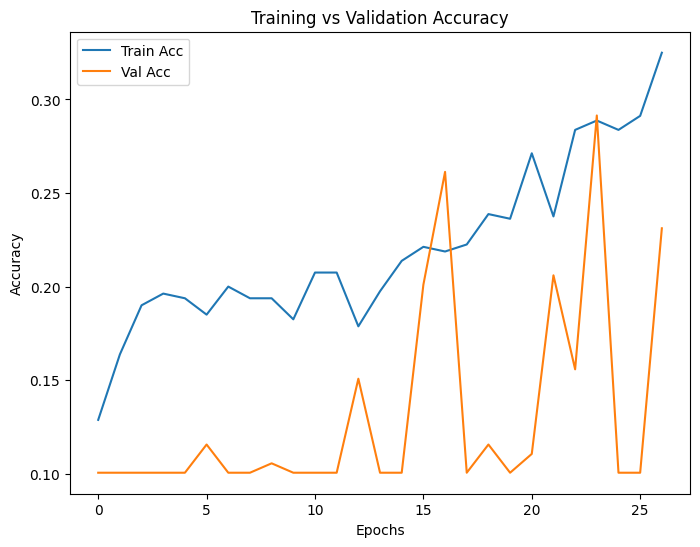

In [290]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


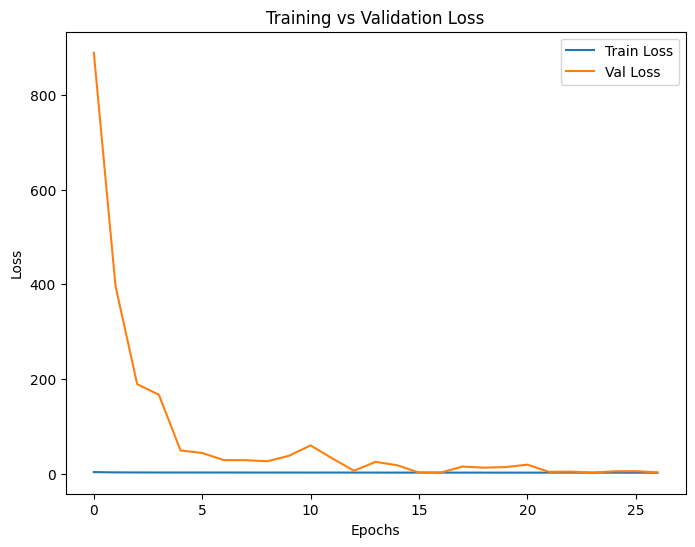

In [291]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step   


<Figure size 2400x2000 with 0 Axes>

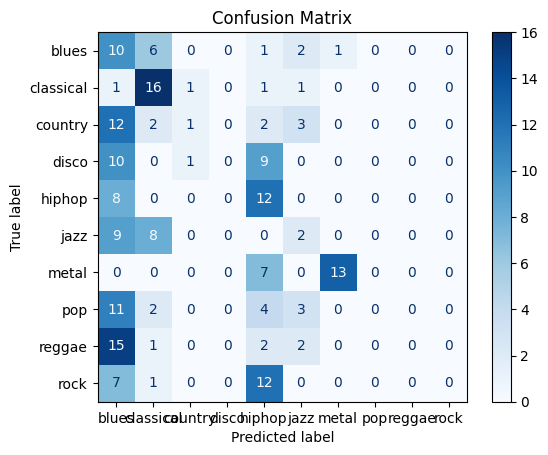

In [292]:
val_gen.reset()
y_true = val_gen.classes
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_gen.class_indices.keys()))

plt.figure(figsize=(24,20))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()